# TorchVision Object Detection Finetuning Tutorial

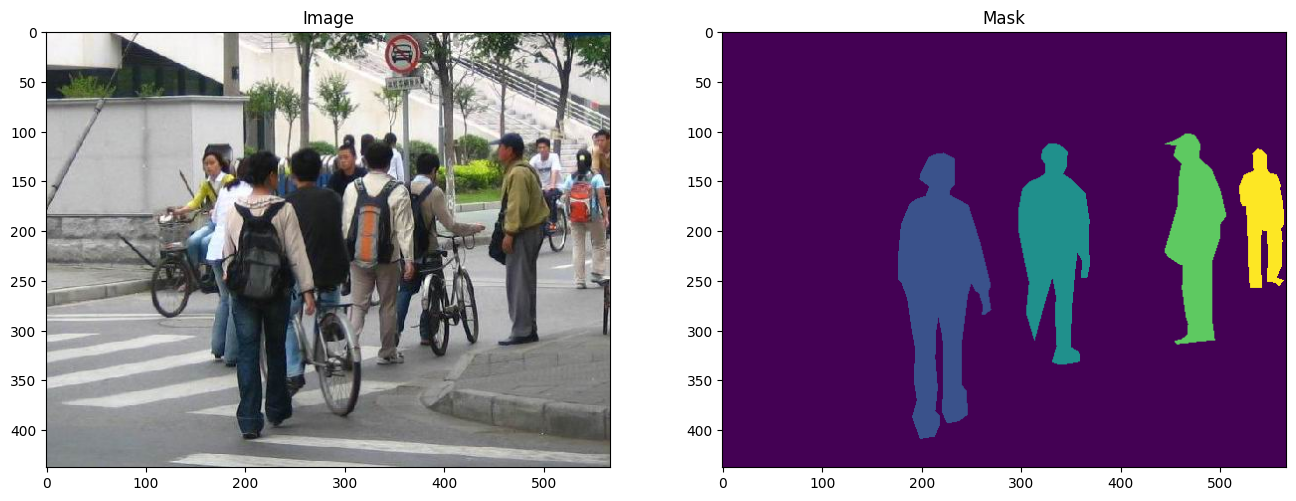

In [2]:
import matplotlib.pyplot as plt
from torchvision.io import read_image

image = read_image("./PennFudanPed/PNGImages/FudanPed00046.png")
mask = read_image("./PennFudanPed/PedMasks/FudanPed00046_mask.png")

plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.title("Image")

plt.imshow(image.permute(1, 2, 0))
plt.subplot(122)
plt.title("Mask")

plt.imshow(mask.permute(1, 2, 0))

In [3]:
import os
import torch
from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision.transforms.v2 import functional as F

class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # Load all image files, sorting them to ensure alignment
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))
        
    def __getitem__(self, idx):
        # Load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = read_image(img_path)
        mask = read_image(mask_path)
        # Instances are encoded as different colors
        obj_ids = torch.unique(mask)
        # First id is the background, so remove it
        obj_ids = obj_ids[1:]
        num_obs = len(obj_ids)
        
        # Split the color-encoded mask into a set of binary masks
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)
        
        # Get bounding box coordinates for each mask
        boxes = masks_to_boxes(masks)
        
        # There is only one class
        labels = torch.ones((num_obs,), dtype=torch.int64)
        
        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # Suppose all instances are not crowd
        iscrowd = torch.zeros((num_obs,), dtype=torch.int64)
        
        # Wrap sample and targets into a dictionary
        target = {}
        target["boxes"] = boxes
        target["masks"] = masks
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        
        if self.transforms is not None:
            img, target = self.transforms(img, target)
            
        return img, target
    
    def __len__(self):
        return len(self.imgs)

# Finetuning from a pretrained model

In [4]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Load a model pretrained on coco 
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

# Replace the classifier with a new one that has
# num_classes which is user_defined
num_classes = 2 # 1 class (person) + background
# Get a number of input features for the classifier 
in_features = model.roi_heads.box_predictor.cls_score.in_features
# Replace the pretrained model head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Modifying the model to add a different backbone

In [5]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# Load a pretrained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features
# FasterRCNN - Needs to know the number of 
# output channels in a backbone. For mobilenet_v2, its 1280
# so we need to add it here
backbone.out_channels = 1280

# The RPN will generate 5 x 3 anchors per spatial location
# with 5 different sizes and 3 different aspect 
# We have Tuple[Tuple[int]] because each feature map
# could potentially have different sizes and aspect ratios
anchor_generator = AnchorGenerator(
    sizes=((32, 64, 128, 256, 512),),
    aspect_ratios=((0.5, 1.0, 2.0),)
)

# Lets define what are the feature maps that we will 
# use to perform the region of interest cropping as well 
# as the size of the crop after rescaling
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# ``OrderedDict[Tensor]``, and in ``featmap_names`` you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(
    featmap_names=['0'],
    output_size=7,
    sampling_ratio=2
)

# Put it al together inside a Fater-RCNN model
model = FasterRCNN(
    backbone,
    num_classes=2,
    rpn_anchor_generator=anchor_generator,
    boi_roi_pool = roi_pooler
)

# Object detection and instance segmentation model for PennFudan Dataset

In [6]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

def get_model_instances_segmentation(num_classes):
    # Load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.mask_rcnn_resnet50_fpn(weights="DEFAULT")

    # Get a number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one

    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes
    )

    # Model will now be ready to be trained and evaluated on your custom dataset
    return model

# Helper Functions for Data Augmentation / Transformation:

In [7]:
from torchvision.transforms import v2 as T

def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomVerticalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

# Testing `forward()` method
We do this because we want to get a idea of what the model expects during training on the sample data

In [17]:
import utils
# utils.py

def collate_fn(batch):
    return tuple(zip(*batch))


model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
dataset = PennFudanDataset("./PennFudanPed", get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    collate_fn= utils.collate_fn
)

# For training
images, targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images, targets) # Returns loss and detections
print(output)

# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x) # Return predictions
print(predictions[0])

AttributeError: module 'utils' has no attribute 'collate_fn'